# Basis Pursuit Denoising via ADMM

We are given the measurements $b = Ax + e$ where $e$ is a measurement noise. 

We solve the problem:

$$
\tag{L1/L2}
{\min}_{x} \| x\|_{1} + \frac{1}{2\rho}\| A x - b \|_2^2
$$

We will work with a sensing matrix $A$ of size $M \times N$ which consists of orthonormal rows.

In [1]:
%load_ext autoreload
%autoreload 2
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
from jax import jit, random
import jax.numpy as jnp
import numpy as np
np.set_printoptions(precision=6)
from jax.numpy.linalg import norm

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import cr.sparse as crs
import cr.sparse.dict as crdict
import cr.sparse.data as crdata
from cr.sparse import lop
from cr.sparse.cvx.adm import yall1

In [5]:
# Problem size
M = 2000
N = 20000
K = 200

In [6]:
# Dictionary Setup
A = crdict.random_orthonormal_rows(crs.KEYS[0],M, N)

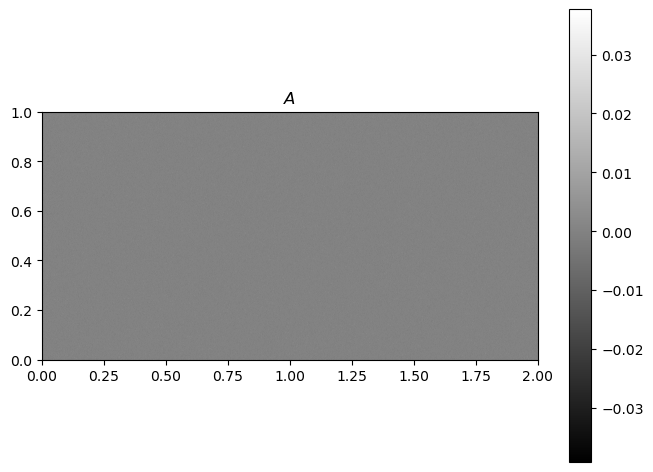

In [7]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(A, extent=[0, 2, 0, 1])
plt.gray()
plt.colorbar()
plt.title(r'$A$');

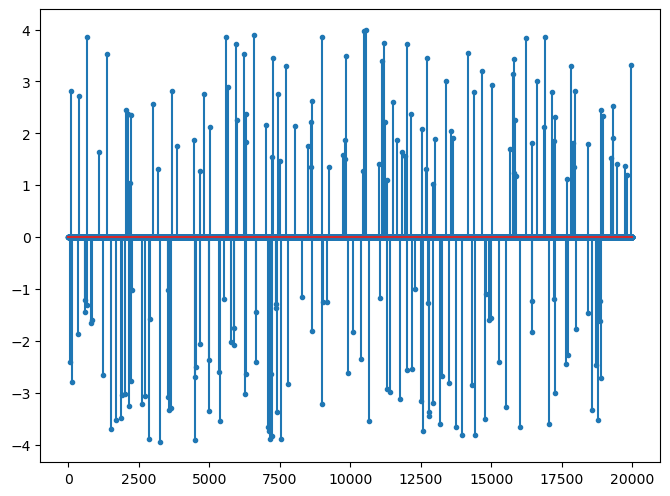

In [8]:
x, omega = crdata.sparse_biuniform_representations(crs.KEYS[1], 1, 4, N, K)
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(x, markerfmt='.');

In [9]:
# Convert A into a linear operator
T = lop.real_matrix(A)
T = lop.jit(T)

In [10]:
# Compute the measurements
b0 = T.times(x)

In [11]:
# Generate some Gaussian noise
sigma = 0.01
noise = sigma * random.normal(crs.KEYS[2], (M,))

In [12]:
# Measure the SNR
crs.snr(b0, noise)

DeviceArray(28.29427, dtype=float64)

In [13]:
# Add measurement noise
b = b0 + noise

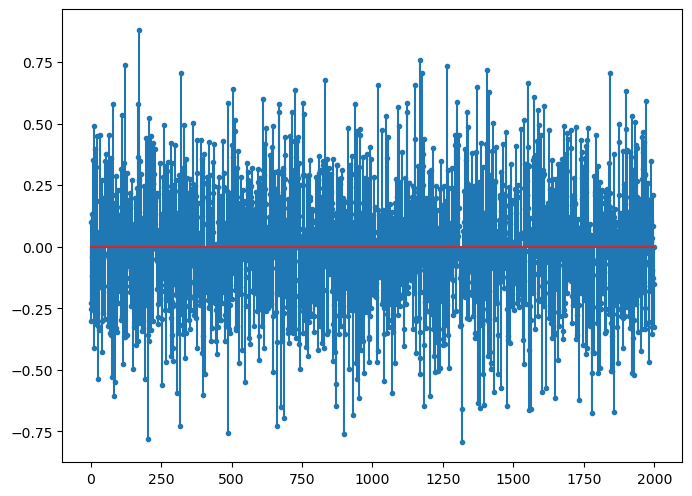

In [14]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(b, markerfmt='.');

In [15]:
# Solve the BPDN problem
sol = yall1.solve(T, b, rho=sigma)

In [16]:
int(sol.iterations), int(sol.n_times), int(sol.n_trans)

(36, 73, 38)

In [17]:
norm(sol.x-x)/norm(x)

DeviceArray(0.026971, dtype=float64)

In [18]:
# The support of K largest non-zero entries in sol.x
omega_rec = crs.largest_indices(sol.x, K)

In [19]:
common = jnp.intersect1d(omega, omega_rec)
total = jnp.union1d(omega, omega_rec)

In [20]:
support_overlap_ratio = len(common) / len(total)
print(support_overlap_ratio)

1.0


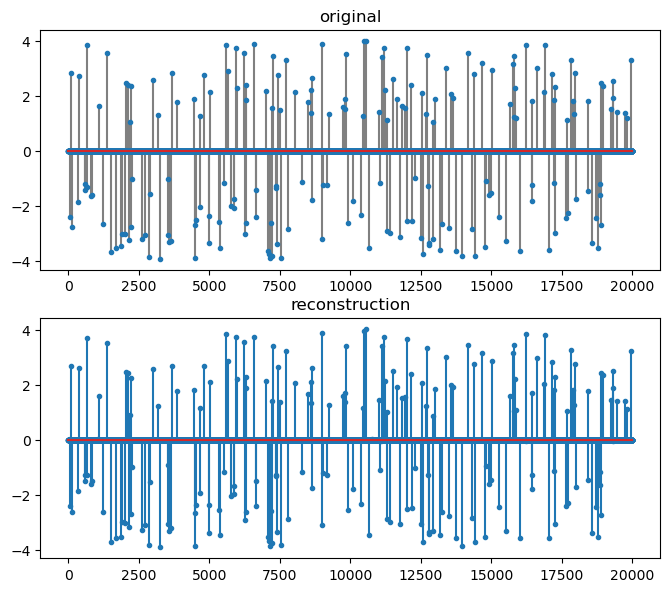

In [21]:
fig=plt.figure(figsize=(8,7), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('original')
plt.stem(x, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(sol.x, markerfmt='.');
plt.title('reconstruction');

In [22]:
%timeit yall1.solve(T, b, rho=sigma).x.block_until_ready()

273 ms ± 773 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
1572 / 273

5.758241758241758